# Rolling window functions: Calculating heatwaves

Let's use Xarray to calculate heatwave statistics over 150 years, for every gridpoint in the CMIP5 ACCESS 1.3 historical run

In [1]:
%matplotlib inline
import xarray
import dask
import numpy
from scipy.stats import norm
from datetime import datetime
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from dask.distributed import Client
c = Client()
c

/home/562/saw562/.local/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


Client Scheduler: tcp://127.0.0.1:46604 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 33.67 GB


We'll start by loading the full tasmax dataset from the NCI archive. The files will be automatically joined, and it will use the dask library to only load the data that it needs.

In [2]:
d = xarray.open_mfdataset('/g/data/rr3/publications/CMIP5/output1/CSIRO-BOM/ACCESS1-3/historical/day/atmos/day/r1i1p1/latest/tasmax/tasmax_day_ACCESS1-3_historical_r1i1p1_*.nc')
tasmax = d.tasmax

## Calculate the 90th percentile temperature for each day of the year

Heatwaves are defined as a period of at least three days where for each day the temperature is in the top 10% for that day of the year - [scorcher.org.au](http://scorcher.org.au/about#measure)

First we'll calculate the climatology - the 90th percentile temperature at each grid point for each day in the year. 

We could use numpy's percentile function to calculate this, but it would be slow. Numpy calculates percentiles by sorting the array and finding the value 90% along the sorted list. Sorting is a terrible operation to perform on a large dataset - it's slow to do and you need the entire array in memory, which is exactly what we're trying to avoid.

Instead let's assume the temperatures are normally distributed, and estimate the 90th percentile from the mean and standard deviation, each of which are fast to calculate. A more thourough investigation would check this assumption.

Calling `.groupby()` on a DataArray lets you use the split-apply-combine strategy on the data
 - Split the data into multiple groups, based on the coordinates
 - Apply a function on each group
 - Combine the groups back into a single dataset

You can group a time axis in particular in many different ways - year, month, day, dayofweek, dayofyear, quarter, season.

There are a number of pre-defined operators you can use as the apply function - `.min()`, `.mean()`, `.std()` etc., or you can define your own.

[`scipy.stats.norm.ppf()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) can be used to get the percentile of a normal distribution, given the mean and standard deviation

[Xarray docs: datetime components](http://xarray.pydata.org/en/stable/time-series.html#datetime-components)  
[Xarray docs: split-apply-combine](http://xarray.pydata.org/en/stable/groupby.html)  
[Xarray docs: GroupBy objects](http://xarray.pydata.org/en/stable/generated/xarray.core.groupby.DataArrayGroupBy.html)

<div class="accordion" id="accordion">
  <div class="card">
    <div class="card-header" id="headingOne">
      <h5 class="mb-0">
        <button class="btn btn-link" type="button" data-toggle="collapse" data-target="#collapse1">
          Answer
        </button>
      </h5>
    </div>
  <div>
    <div id="collapse1" class="collapse" data-parent="#accordion">
      <div class="card-body">
<pre><code>
# Get the mean and standard deviation for each grid point and day of year
mean = tasmax.groupby('time.dayofyear').mean('time')
std = tasmax.groupby('time.dayofyear').std('time')

# Get the 90th percentile for each grid point and day of year, assuming normal distributions
p90 = xarray.DataArray(norm.ppf(0.9, loc=mean, scale=std), coords=mean.coords)
</code></pre>
      </div>
    </div>
  </div>
</div>

In [4]:
def calc_p90(tasmax):
    mean = tasmax.groupby('time.dayofyear').mean('time')
    std = tasmax.groupby('time.dayofyear').std('time')
    
    # Get the 90th percentile for each grid point and day of year, assuming normal distributions
    p90 = xarray.DataArray(norm.ppf(0.9, loc=mean, scale=std), coords=mean.coords)
    p90.name = 'p90'
    return p90

#p90 = calc_p90(tasmax)
#p90.to_netcdf('p90.nc')

In [3]:
p90 = xarray.open_dataset('p90.nc').p90

## Find candidate points

With the climatology we can find the locations where the maximum temperature exceeds the 90th percentile for that day of the year. 

Use [`.where()`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html) to filter the temperature field, so that it only contains grid points where the temperature exceeds the 90th percentile calculated above

For best results here you should use a recent version of dask (after June 2018), as comparing against a climatology was dramatically improved.

[Xarray docs: `.where()`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html)

<div class="accordion" id="accordion">
  <div class="card">
    <div class="card-header" id="headingOne">
      <h5 class="mb-0">
        <button class="btn btn-link" type="button" data-toggle="collapse" data-target="#collapse2">
          Answer
        </button>
      </h5>
    </div>
  <div>
    <div id="collapse2" class="collapse" data-parent="#accordion">
      <div class="card-body">
<pre><code>
candidates = tasmax.where((tasmax.groupby('time.dayofyear') - p90) > 0)
</code></pre>
      </div>
    </div>
  </div>
</div>
    
    

In [4]:
t = tasmax.sel(time=slice('19500101','19990101'))
candidates = t.where((t.groupby('time.dayofyear') - p90) > 0)

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/xarray/core/indexing.py:1168: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


In [61]:
tasmax

<xarray.DataArray 'tasmax' (time: 56978, lat: 145, lon: 192)>
dask.array<shape=(56978, 145, 192), dtype=float32, chunksize=(9131, 145, 192)>
Coordinates:
  * lat      (lat) float64 -90.0 -88.75 -87.5 -86.25 -85.0 -83.75 -82.5 ...
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 9.375 11.25 13.12 15.0 ...
    height   float64 1.5
  * time     (time) datetime64[ns] 1850-01-01T12:00:00 1850-01-02T12:00:00 ...
Attributes:
    standard_name:     air_temperature
    long_name:         Daily Maximum Near-Surface Air Temperature
    units:             K
    cell_methods:      time: maximum
    cell_measures:     area: areacella
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

In [7]:
c.get_versions(check=True)

{'scheduler': {'host': [['python', '3.6.5.final.0'],
   ['python-bits', 64],
   ['OS', 'Linux'],
   ['OS-release', '2.6.32-754.2.1.el6.x86_64'],
   ['machine', 'x86_64'],
   ['processor', 'x86_64'],
   ['byteorder', 'little'],
   ['LC_ALL', 'None'],
   ['LANG', 'en_AU.UTF-8'],
   ['LOCALE', 'en_AU.UTF-8']],
  'packages': {'required': [['dask', '0.18.1+48.g4ed1d87'],
    ['distributed', '1.21.8'],
    ['msgpack', '0.5.6'],
    ['cloudpickle', '0.5.3'],
    ['tornado', '5.0.2'],
    ['toolz', '0.9.0']],
   'optional': [['numpy', '1.14.5'],
    ['pandas', '0.23.1'],
    ['bokeh', '0.12.16'],
    ['lz4', None],
    ['blosc', None]]}},
 'workers': {'tcp://127.0.0.1:33034': {'host': [['python', '3.6.5.final.0'],
    ['python-bits', 64],
    ['OS', 'Linux'],
    ['OS-release', '2.6.32-754.2.1.el6.x86_64'],
    ['machine', 'x86_64'],
    ['processor', 'x86_64'],
    ['byteorder', 'little'],
    ['LC_ALL', 'None'],
    ['LANG', 'en_AU.UTF-8'],
    ['LOCALE', 'en_AU.UTF-8']],
   'packages': {'re

In [5]:
x = dask.array.where((t.groupby('time.dayofyear') - p90) > 0, dask.array.ones(t.shape, chunks=(1,145,192)), dask.array.zeros(t.shape, chunks=(1,145,192)))
#x[1,:,:].visualize()

#plt.imshow(x[1,:,:].compute())

In [5]:
filter = (t.groupby('time.dayofyear') - p90) > 0

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/xarray/core/indexing.py:1168: PerformanceWarning: Slicing with an out-of-order index is generating 25 times more chunks
  return self.array[key]


In [22]:
def subtract_p90(x):
    return x.groupby('time.dayofyear') - p90

(t.sel(time='1998'))[:,100,100].load()

KeyboardInterrupt: 

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker


In [11]:
%%time
x[:,100,100].compute()

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53856 remote=tcp://127.0.0.1:41315>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48300 remote=tcp://127.0.0.1:41877>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53862 remote=tcp://127.0.0.1:41315>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:53864 remote=tcp://127.0.0.1:41315>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48306 remote=tcp://127.0.0.1:41877>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:48308 remote=tcp://127.0.0.1:41877>
distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 15926 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker process 16398 exited

KeyboardInterrupt: 

In [83]:
%%time
candidates[:,100,100].values

distributed.nanny - WARNING - Worker exceeded 95% memory budget.  Restarting
distributed.nanny - WARNING - Worker process 14210 was killed by unknown signal
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

## Create a timeseries plot for a single location

Now for a bit of signal processing. We have an array of candidate times and locations, but it's only a heatwave for a location if there are at least three consecutive times.

We want to calculate the number of heatwaves at each location. The easiest way to think about this is to narrow down our data while we get a handle on our data.

Create a plot of the temperature at a single location for a single year, and overlay the candidate points onto the plot

Here's some locations to try:

Sydney: lat -33.9 lon 151.2,
Melbourne: lat -37.8 lon 145.0,
Canberra: lat -35.3 lon 149.1,
Hobart: lat -42.9 lon 147.3

[Xarray docs: Nearest neighbour lookups](http://xarray.pydata.org/en/stable/indexing.html#nearest-neighbor-lookups)

<div class="accordion" id="accordion">
  <div class="card">
    <div class="card-header" id="headingOne">
      <h5 class="mb-0">
        <button class="btn btn-link" type="button" data-toggle="collapse" data-target="#collapse3">
          Answer
        </button>
      </h5>
    </div>
  <div>
    <div id="collapse3" class="collapse" data-parent="#accordion">
      <div class="card-body">
<pre><code>
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(color='red')
</code></pre>
      </div>
    </div>
  </div>
</div>

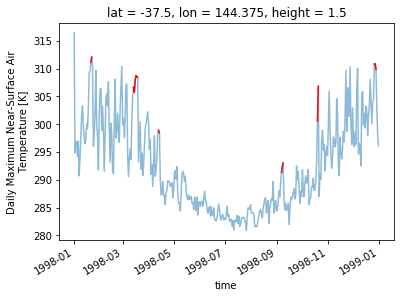

In [76]:
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(color='red')

## Identify heatwaves with a basic window function

To help with processing time series Xarray has rolling window functions, which can help with things like temporal smoothing. We'll use this feature to find times where there are three consecutive candidate points - these will be our heatwaves.

You can set up a window function collecting 3 samples in the time dimension using `.rolling(time=3)`. Just like `.groupby()` there are a number of reduction calculations you can use on the window.

Use `.rolling()` and a reduction function to mark heatwaves on the plot you created in the previous step.

[Xarray docs: `.rolling()`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.rolling.html#xarray.DataArray.rolling)  
[Xarray docs: Rolling objects](http://xarray.pydata.org/en/stable/generated/xarray.core.rolling.DataArrayRolling.html#xarray.core.rolling.DataArrayRolling)

<div class="accordion" id="accordion">
  <div class="card">
    <div class="card-header" id="headingOne">
      <h5 class="mb-0">
        <button class="btn btn-link" type="button" data-toggle="collapse" data-target="#collapse4">
          Answer
        </button>
      </h5>
    </div>
  <div>
    <div id="collapse4" class="collapse" data-parent="#accordion">
      <div class="card-body">
<pre><code>
tasmax.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(alpha=0.5)
candidates.sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(color='red')

# To plot this on the same axis I'm filtering the candidates with .where() to show times when a heatwave was found
candidates.where(
    candidates.rolling(time=3).count()==3
).sel(lat=-37.8, lon=144.9, method='nearest').sel(time='1998').plot(marker='.')
</code></pre>
      </div>
    </div>
  </div>
</div>

## Zoom in on some events

Did you find any heatwaves? Zoom in on a few to see how well our filter worked (It may help to add markers with `.plot(marker='.')`)

## More advanced filters

As a first pass this works but it is a bit crude - it correctly identifies heatwaves, but doesn't allow us to count them. To do that, I need to define a custom filter function to apply to the window.

To count the heatwaves I need to be a bit more specific than I have been, since each instance occurs over a number of time points. Let's say I want to count the *starts* of the heatwaves - where it transitions from not a candidate to a candidate for 3 steps, so I want to match the pattern
```
[ nan, valid, valid, valid ]
```
with the second point being marked as the date the heatwave starts. To do this I've created the filter function below. So that the times get marked correctly the function is intended to be used with a centred window function - it returns true if the entry one to the left is `nan` and that the current entry plus the two to the right are finite values, false otherwise.

In [ ]:
def rising_filter(array, axis):
    """
    Returns locations when the values of array go from nan to valid for at least 3 steps
    
    This should be used with a centred, 5 element window like
        x.rolling(time=5, center=True, min_periods=1).reduce(rising_filter)
        
    Note that applying this to a Dask array will load the entire input array
    """
    # Make sure there are enough points
    assert(array.shape[axis] == 5)
    # Make sure we're working on the last axis
    assert(axis == array.ndim-1 or axis == -1)
    
    # One entry to the left, should be nan
    left = array[..., 1]
    # This entry onwards, should not be nan
    right = array[..., 2:].sum(axis=axis)

    return numpy.logical_and(numpy.isnan(left), numpy.isfinite(right))

In theory this function can be applied to our data using
```
heatwave_starts = candidates.rolling(time=5, center=True, min_periods=1).reduce(rising_filter)
```
unfortunately however this doesn't play well with dask, which is the library that handles loading the data from the input files as we need it. If we try then the entire 150 years of daily data gets loaded into memory, and our program will crash.

So that we don't need to load the whole array into memory, we need to wrap our filter function using `xarray.apply_ufunc(..., dask='parallelized')`. This tells dask that it can apply the filter on chunks one at a time, it doesn't need the whole array.

In [ ]:
def rising_filter_dask(x, dim):
    """
    Helper function for applying rising_filter() to a dask array without loading the whole thing
    
    Use like
        rising_filter_dask(x.rolling(time=5, center=True, min_periods=1).construct('rolling_dim'),
                           dim='rolling_dim')
    """
    return xarray.apply_ufunc(rising_filter, x, input_core_dims=[[dim]],
                             kwargs={'axis': -1},
                             dask='parallelized',
                             output_dtypes=[bool])

The dask version of the filter has to be applied slightly differently - this seems to be a bug?

In [ ]:
windows = candidates.chunk({'time':20}).rolling(time=5, center=True, min_periods=1).construct('rolling_dim')
heatwave_starts = rising_filter_dask(windows, dim='rolling_dim')

## Analysing the whole dataset

Finally we have a DataArray with the start time of every heatwave at every gridpoint in the ACCESS 1.3 historical run, that's pretty cheap to calculate - the run time of this notebook should be just a couple minutes.

From here we can do some analysis -

 * Where do heatwaves occur the most? - Create a map of how many heatwaves occured at each grid point between 1990 and 2000
 
<div class="accordion" id="accordion">
  <div class="card">
    <div class="card-header" id="headingOne">
      <h5 class="mb-0">
        <button class="btn btn-link" type="button" data-toggle="collapse" data-target="#collapse5">
          Answer
        </button>
      </h5>
    </div>
  <div>
    <div id="collapse5" class="collapse" data-parent="#accordion">
      <div class="card-body">
<pre><code>
%%time
# Takes around 30 seconds
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
(heatwave_starts.sel(time=slice('1990','2000')).sum('time')/10).plot(ax=ax)
ax.coastlines()
ax.set_title('Mean yearly heatwave count, 1990-2000 CMIP5 ACCESS 1.3 historical')
</code></pre>
      </div>
    </div>
  </div>
</div>
 
 * How does the frequency change with time? - Create a time-series plot of heatwaves at a single location
 
<div class="accordion" id="accordion">
  <div class="card">
    <div class="card-header" id="headingOne">
      <h5 class="mb-0">
        <button class="btn btn-link" type="button" data-toggle="collapse" data-target="#collapse6">
          Answer
        </button>
      </h5>
    </div>
  <div>
    <div id="collapse6" class="collapse" data-parent="#accordion">
      <div class="card-body">
<pre><code>
%%time
# Takes about 3 minutes
heatwave_starts.sel(lat=-37.8, lon=144.9, method='nearest').groupby('time.year').sum('time').plot()
plt.title('Melbourne heatwaves by year, CMIP5 ACCESS 1.3 historical')
</code></pre>
      </div>
    </div>
  </div>
</div>

## Saving the data

Before saving the data to disk, here are a few things to think about

 - Do I need to save the data?
 - How much data am I creating?
 - Is the data easy to re-create if I lose it?
 - Will I know what's in the file in 6 months time?
 - Can I use compression?

In [ ]:
%%time
heatwaves = xarray.Dataset({'heatwave_start': heatwave_starts})

heatwaves.heatwave_start.attrs['description'] = 'Value is "1" if a heatwave started at this time and location, "0" otherwise'

heatwaves.attrs['title'] = 'Heatwave start times from ACCESS 1.3 historical CMIP5 simulation'
heatwaves.attrs['institution'] = 'ARC Centre of Excellence for Climate Extremes'
heatwaves.attrs['source'] = 'CMIP5 ACCESS 1.3 historical r1i1p1 daily tasmax'
heatwaves.attrs['history'] = "%s: Calculated using Ipython notebook"%datetime.now()

heatwaves.sel(time='1998').to_netcdf('heatwaves.nc', 
                    encoding={'heatwave_start': {
                        'zlib':True,
                        'chunksizes': [200,145,192],
                    }})

In [ ]:
! ncdump -hs heatwaves.nc
! ls -sh heatwaves.nc